In [1]:
# Tutorial de Extração de Componentes Principais de Discriminação no banco de dados Iris

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ

In [1]:
# Import Libs
import time
init_time = time.time()

import os
import pickle
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 20

current_time = time.time()
print 'Time to import libraries: %1.3f seconds'%(current_time-init_time)

Time to import libraries: 4.495 seconds


In [2]:
# Read Data
from keras.utils import np_utils

init_time = time.time()

from sklearn import datasets

# import some data to play with
iris = datasets.load_iris()
data = iris.data # iris data
trgt = iris.target # iris data
iris_colors = ['b','r','g']
iris_labels = ['Setosa','Versicolor','Virginica']

# for classification -> target max sparse
trgt_sparse = np_utils.to_categorical(trgt)

current_time = time.time()
print 'Time to import data: %1.3f seconds'%(current_time-init_time)

Using Theano backend.


Time to import data: 2.454 seconds


In [33]:
from sklearn import cross_validation
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils
from keras.layers import Merge


def pcdi_extractor(inputdata, targetdata, trn_params=None):
    ''' 
        This function extracts the Independent Principal Components of Discrimination of a Dataset
        
        Parameters:
            inputdata: dataset with inputs
            
            targetdata: each class -> an integer
            
            trn_params: train parameters
            
            trn_params['n_folds'] = number of cross validation folds
            trn_params['n_inits'] = number of initializations
            trn_params['n_pcds'] = number of PCDs to be extracted
            trn_params['norm'] = normalization
            trn_params['learning_rate'] = learning rate
            trn_params['learning_decay'] = learning rate decay
            trn_params['momentum'] = momentum
            trn_params['nesterov'] = nesterov momentum
            trn_params['train_verbose'] = train verbose
            trn_params['n_epochs'] = number of epochs
            trn_params['batch_size'] = batch size
        
    '''
    
    if trn_params == None:
        trn_params = {}
        trn_params['n_folds'] = 2
        trn_params['n_inits'] = 2
        trn_params['n_pcds'] = 2
        trn_params['norm'] = 'none'
        trn_params['learning_rate'] = 0.01
        trn_params['learning_decay'] = 1e-6
        trn_params['momentum'] = 0.3
        trn_params['nesterov'] = True
        trn_params['train_verbose'] = False
        trn_params['n_epochs'] = 300
        trn_params['batch_size'] = 8

    print 'PCD Independent Extractor'
    print 'trn_params: ',trn_params
    
    # trained classifiers
    classifiers = {}
    trn_desc = {}
    pcds = {}
    
    CVO = cross_validation.StratifiedKFold(targetdata, trn_params['n_folds'])
    CVO = list(CVO)
    
    # from each class an integer -> target max sparse
    targetdata_sparse = np_utils.to_categorical(targetdata)
    
    for ifold in range(trn_params['n_folds']):
        train_id, test_id = CVO[ifold]

        # normalize data based in train set
        if trn_params['norm'] == 'mapstd':
            scaler = preprocessing.StandardScaler().fit(inputdata[train_id,:])
        elif trn_params['norm'] == 'mapstd_rob':
            scaler = preprocessing.RobustScaler().fit(inputdata[train_id,:])
        elif trn_params['norm'] == 'mapminmax':
            scaler = preprocessing.MinMaxScaler().fit(inputdata[train_id,:])
        
        if trn_params['norm'] != "none":
            norm_inputdata = scaler.transform(inputdata)
        else:
            norm_inputdata = inputdata
         
        
        classifiers[ifold] = {}
        trn_desc[ifold] = {}
        pcds[ifold] = {}
        
        for ipcd in range(trn_params['n_pcds']):
            best_init = 0
            best_loss = 999
            
            if ipcd == 0:
                # first pcd - random init
                for i_init in range(trn_params['n_inits']):
                    # create the model
                    model = Sequential()
                    
                    # add a linear layer to isolate the input of NN model
                    model.add(Dense(norm_inputdata.shape[1],
                                input_dim=norm_inputdata.shape[1], 
                                init='identity',trainable=False))
                    model.add(Activation('linear'))
                    
                    # add a non-linear single neuron layer to compress all information
                    model.add(Dense(1, input_dim=norm_inputdata.shape[1], init='uniform'))
                    model.add(Activation('tanh'))
                    
                    # add a non-linear output layer with max sparse target shape
                    model.add(Dense(targetdata_sparse.shape[1], init='uniform')) 
                    model.add(Activation('tanh'))
                    
                    # creating a optimization function using steepest gradient
                    sgd = SGD(lr=trn_params['learning_rate'],
                              decay=trn_params['learning_decay'],
                              momentum=trn_params['momentum'],
                              nesterov=trn_params['nesterov'])
                    
                    # compile the model
                    model.compile(loss='mean_squared_error', 
                                  optimizer=sgd,
                                  metrics=['accuracy','mean_squared_error'])
                    
                    # early stopping to avoid overtraining
                    earlyStopping = callbacks.EarlyStopping(
                        monitor='val_loss', patience=25,
                        verbose=0, mode='auto')
                    
                    # Train model
                    init_trn_desc = model.fit(norm_inputdata[train_id], targetdata_sparse[train_id],
                                              nb_epoch=trn_params['n_epochs'], 
                                              batch_size=trn_params['batch_size'],
                                              callbacks=[earlyStopping], 
                                              verbose=trn_params['train_verbose'],
                                              validation_data=(norm_inputdata[test_id],
                                                               targetdata_sparse[test_id]),
                                              shuffle=True)
                    
                    if np.min(init_trn_desc.history['val_loss']) < best_loss:
                        best_init = i_init
                        best_loss = np.min(init_trn_desc.history['val_loss'])
                        classifiers[ifold][ipcd] = model
                        trn_desc[ifold][ipcd] = init_trn_desc
                        pcds[ifold][ipcd] = model.layers[2].get_weights()[0]
                    
                    print ('Fold: %i of %i - PCD: %i of %i - Init: %i of %i - finished with val cost: %1.3f'%
                           (ifold+1,trn_params['n_folds'],
                            ipcd+1,trn_params['n_pcds'],
                            i_init+1,trn_params['n_inits'],
                            best_loss
                           ))
                    
            else: # ipcd != 0
                # from second pcd to the end - orthogonal init
                for i_init in range(trn_params['n_inits']):
                    # create the model
                    model = Sequential()
                    
                    # add a linear layer to isolate the input of NN model
                    model.add(Dense(norm_inputdata.shape[1],
                                input_dim=norm_inputdata.shape[1], 
                                init='identity',trainable=False))
                    model.add(Activation('linear'))
                    
                    # add a non-linear single neuron layer to compress all information
                    model.add(Dense(1, input_dim=norm_inputdata.shape[1], init='uniform'))
                    model.add(Activation('tanh'))
                    
                    # add a non-linear output layer with max sparse target shape
                    model.add(Dense(targetdata_sparse.shape[1], init='uniform')) 
                    model.add(Activation('tanh'))
                    
                    # creating a optimization function using steepest gradient
                    sgd = SGD(lr=trn_params['learning_rate'],
                              decay=trn_params['learning_decay'],
                              momentum=trn_params['momentum'],
                              nesterov=trn_params['nesterov'])
                    
                    # compile the model
                    model.compile(loss='mean_squared_error', 
                                  optimizer=sgd,
                                  metrics=['accuracy','mean_squared_error'])
                    
                    # early stopping to avoid overtraining
                    earlyStopping = callbacks.EarlyStopping(
                        monitor='val_loss', patience=25,
                        verbose=0, mode='auto')
                    
                    
                    # remove the projection of previous extracted pcds from random init weights
                    w = model.layers[2].get_weights()[0]
                    w_proj = np.zeros_like(w)
                    for i_old_pcd in range(ipcd):
                        w_proj = w_proj + (np.inner(np.inner(pcds[ifold][i_old_pcd],w), 
                                                    pcds[ifold][i_old_pcd].T)/
                                           np.inner(pcds[ifold][i_old_pcd].T, 
                                                    pcds[ifold][i_old_pcd].T))
                    w_remove_proj = w - w_proj
                    weights = model.layers[2].get_weights()
                    weights[0] = w_remove_proj
                    model.layers[2].set_weights(weights)
                    
                    # remove the projection of previous extracted pcds from data
                    data_proj = np.zeros_like(norm_inputdata)
                    for i_old_pcd in range(ipcd-1):
                        data_proj = (data_proj + 
                                     (np.inner(np.inner(pcds[ifold][i_old_pcd].T,
                                                        norm_inputdata).T,
                                               pcds[ifold][i_old_pcd])/
                                      np.inner(pcds[ifold][i_old_pcd].T,
                                               pcds[ifold][i_old_pcd].T)))
                    train_data = norm_inputdata - data_proj
                    
                    # Train model with modified data
                    init_trn_desc = model.fit(train_data[train_id], targetdata_sparse[train_id],
                                              nb_epoch=trn_params['n_epochs'], 
                                              batch_size=trn_params['batch_size'],
                                              callbacks=[earlyStopping], 
                                              verbose=trn_params['train_verbose'],
                                              validation_data=(train_data[test_id],
                                                               targetdata_sparse[test_id]),
                                              shuffle=True)
                    
                    if np.min(init_trn_desc.history['val_loss']) < best_loss:
                        best_init = i_init
                        best_loss = np.min(init_trn_desc.history['val_loss'])
                        classifiers[ifold][ipcd] = model
                        trn_desc[ifold][ipcd] = init_trn_desc
                        pcds[ifold][ipcd] = model.layers[2].get_weights()[0]
                    
                    
                    print ('Fold: %i of %i - PCD: %i of %i - Init: %i of %i - finished with val cost: %1.3f'%
                           (ifold+1,trn_params['n_folds'],
                            ipcd+1,trn_params['n_pcds'],
                            i_init+1,trn_params['n_inits'],
                            best_loss
                           ))

    # add cross-validation information in train desc.
    trn_desc['CVO'] = CVO
    
    return [pcds,classifiers,trn_desc]

In [34]:
# Extract PCD Independent
trn_params = {}
trn_params['n_folds'] = 2
trn_params['n_inits'] = 2
trn_params['n_pcds'] = 4
trn_params['norm'] = 'mapstd'
trn_params['learning_rate'] = 0.01
trn_params['learning_decay'] = 1e-4
trn_params['momentum'] = 0.9
trn_params['nesterov'] = True
trn_params['train_verbose'] = False
trn_params['n_epochs'] = 1000
trn_params['batch_size'] = 3


[pcds,classifiers,trn_desc] = pcdi_extractor(data,trgt, trn_params)

PCD Independent Extractor
trn_params:  {'nesterov': True, 'learning_rate': 0.01, 'n_inits': 2, 'batch_size': 3, 'n_epochs': 1000, 'train_verbose': False, 'learning_decay': 0.0001, 'momentum': 0.9, 'n_folds': 2, 'norm': 'mapstd', 'n_pcds': 4}
Fold: 1 of 2 - PCD: 1 of 4 - Init: 1 of 2 - finished with val cost: 0.111
Fold: 1 of 2 - PCD: 1 of 4 - Init: 2 of 2 - finished with val cost: 0.111
Fold: 1 of 2 - PCD: 2 of 4 - Init: 1 of 2 - finished with val cost: 0.111
Fold: 1 of 2 - PCD: 2 of 4 - Init: 2 of 2 - finished with val cost: 0.111
Fold: 1 of 2 - PCD: 3 of 4 - Init: 1 of 2 - finished with val cost: 0.145
Fold: 1 of 2 - PCD: 3 of 4 - Init: 2 of 2 - finished with val cost: 0.145
Fold: 1 of 2 - PCD: 4 of 4 - Init: 1 of 2 - finished with val cost: 0.111
Fold: 1 of 2 - PCD: 4 of 4 - Init: 2 of 2 - finished with val cost: 0.111
Fold: 2 of 2 - PCD: 1 of 4 - Init: 1 of 2 - finished with val cost: 0.112
Fold: 2 of 2 - PCD: 1 of 4 - Init: 2 of 2 - finished with val cost: 0.112
Fold: 2 of 2 - PCD

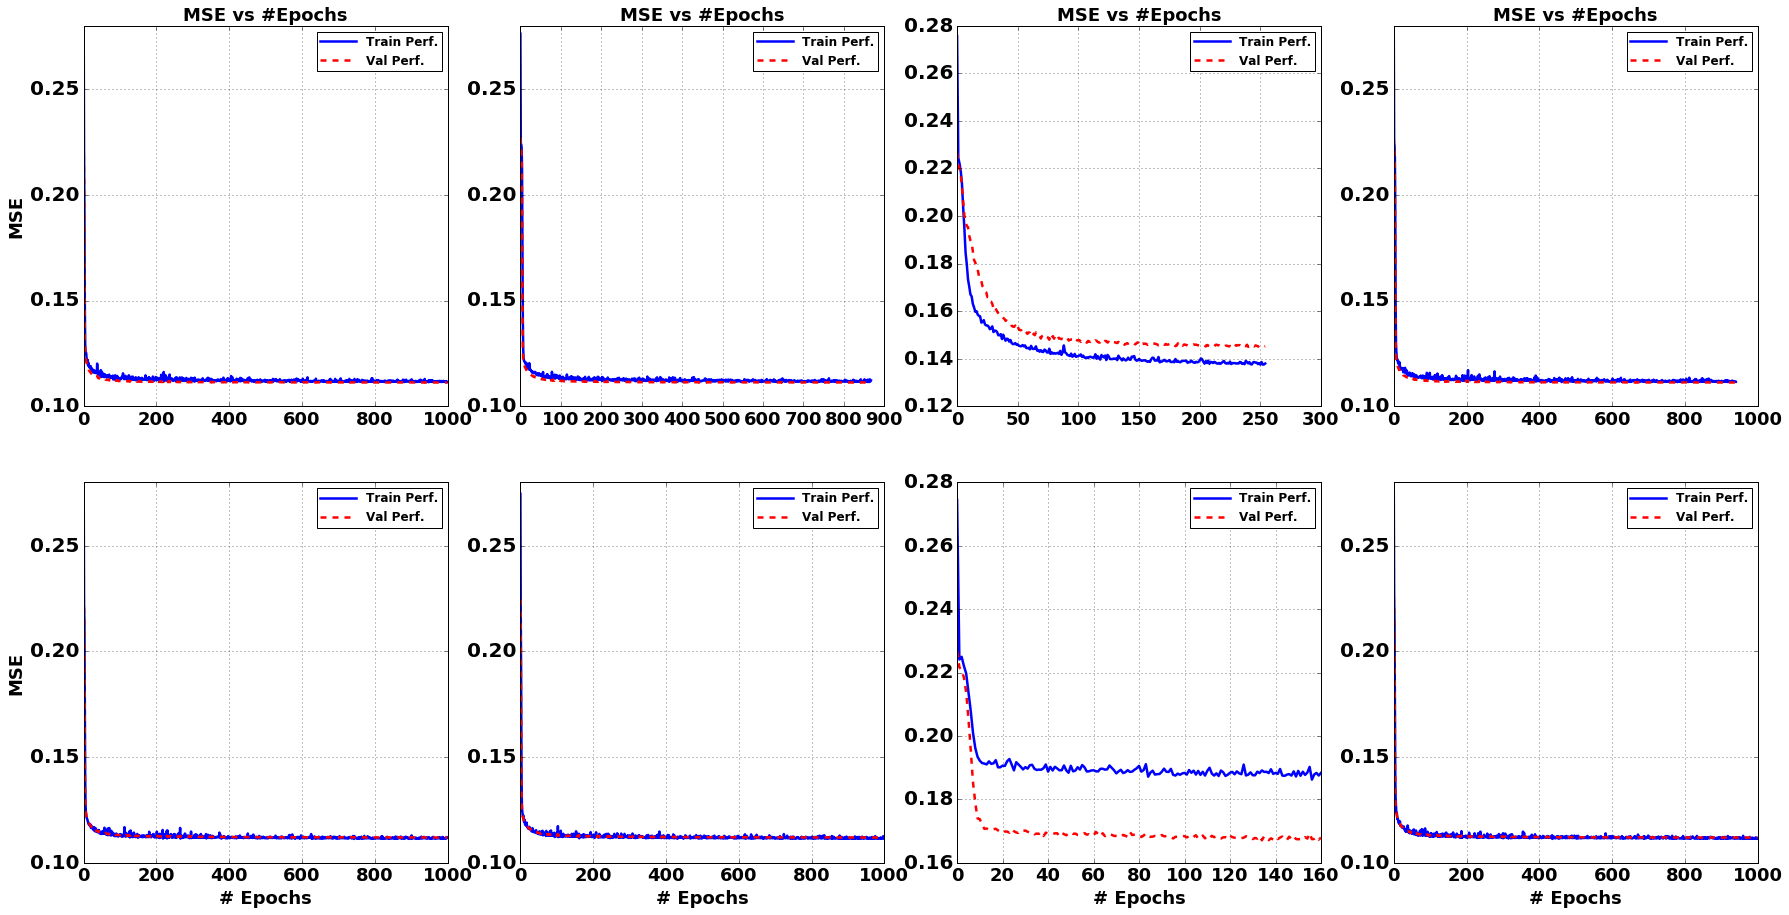

In [35]:
# show train evolution
%matplotlib inline 

fig, ax = plt.subplots(figsize=(30,15),nrows=trn_params['n_folds'], ncols=trn_params['n_pcds'])

for ifold in range(trn_params['n_folds']):
    for ipcd in range(trn_params['n_pcds']):
        ax[ifold,ipcd].plot(trn_desc[ifold][ipcd].epoch,
                            trn_desc[ifold][ipcd].history['loss'],color=[0,0,1],
                            linewidth=2.5,linestyle='solid',label='Train Perf.')

        ax[ifold,ipcd].plot(trn_desc[ifold][ipcd].epoch,
                            trn_desc[ifold][ipcd].history['val_loss'],color=[1,0,0],
                            linewidth=2.5,linestyle='dashed',label='Val Perf.')
        ax[ifold,ipcd].grid(True)
        ax[ifold,ipcd].legend()
        
        if ifold == 0:
            ax[ifold,ipcd].set_title("MSE vs #Epochs",fontsize=18,fontweight='bold')
        if ifold == trn_params['n_folds']-1:
            ax[ifold,ipcd].set_xlabel("# Epochs",fontsize=18,fontweight='bold')
        if ipcd == 0:
            ax[ifold,ipcd].set_ylabel('MSE',fontsize=18,fontweight='bold')

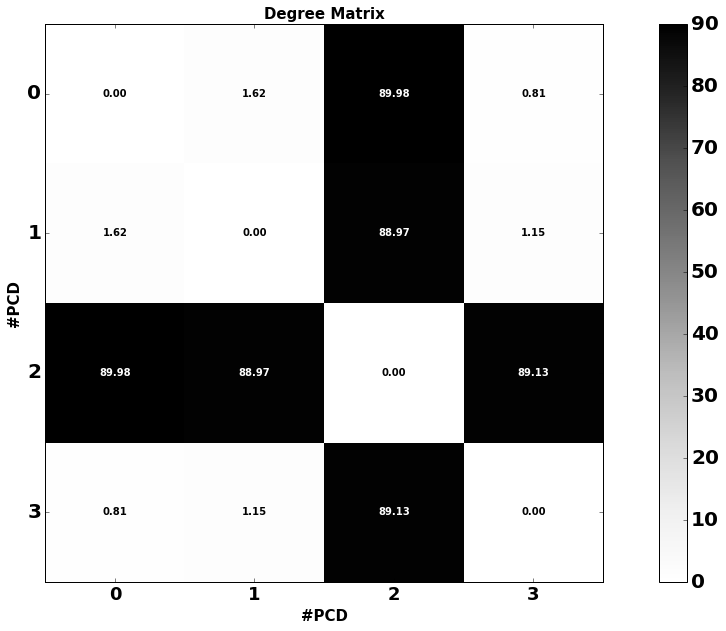

In [36]:
# measure the pcd degree

choose_fold = 0

degree_matrix = np.zeros([trn_params['n_pcds'],trn_params['n_pcds']])

for ipcd in range(trn_params['n_pcds']):
    for jpcd in range(trn_params['n_pcds']):
        degree = (np.inner(pcds[choose_fold][ipcd].T,pcds[choose_fold][jpcd].T)/
                 (np.linalg.norm(pcds[choose_fold][ipcd])*
                  np.linalg.norm(pcds[choose_fold][jpcd])))
        degree = round(degree.real,4)
        degree = np.arccos(degree)
        degree = np.degrees(degree)
        if degree > 90 and degree < 180:
            degree = degree - 180
        if degree > 180 and degree < 270:
            degree = degree - 180
        if degree == 180:
            degree = degree - 90
        
        degree_matrix[ipcd,jpcd] = np.abs(degree)
        
%matplotlib inline  

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_aspect(1)

im =ax.imshow(degree_matrix, interpolation='nearest', cmap=plt.cm.Greys,clim=(0.0, 90.0))
width, height = degree_matrix.shape

for x in xrange(width):
    for y in xrange(height):
        if degree_matrix[x][y] < 45.:
            ax.annotate('%1.2f'%(degree_matrix[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center')
        else:
            ax.annotate('%1.2f'%(degree_matrix[x][y]), xy=(y, x),
                        horizontalalignment='center',
                        verticalalignment='center',color='white')

ax.set_title('Degree Matrix',fontweight='bold',fontsize=15)
ax.set_ylabel('#PCD',fontweight='bold',fontsize=15)
ax.set_xlabel('#PCD',fontweight='bold',fontsize=15)
fig.colorbar(im)

tick_marks = np.arange(trn_params['n_pcds'])
ax.xaxis.set_ticks(tick_marks)
ax.yaxis.set_ticks(tick_marks)


In [32]:
# measure classification efficiency per #PCD

